Stworzymy kompletny przykład, który obejmuje generowanie danych, ich przetwarzanie oraz automatyczne generowanie wykresów i podstawowych analiz statystycznych. Przykład będzie dotyczył symulacji danych sprzedaży produktów w ciągu ostatniego roku, a następnie przeprowadzenia analizy miesięcznej sprzedaży oraz porównania sprzedaży między produktami.

### Krok 1: Generowanie danych

Pierwszy krok to stworzenie pliku CSV zawierającego symulowane dane sprzedaży. Dane będą obejmować daty sprzedaży, nazwy produktów i ilości sprzedanych sztuk.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

# Symulacja danych sprzedaży
np.random.seed(42)  # Dla powtarzalności wyników
daty = pd.date_range(start="2023-01-01", end="2023-12-31", freq='D')
produkty = ['Produkt A', 'Produkt B', 'Produkt C']
ilosci = np.random.randint(1, 20, size=(len(daty), len(produkty)))

# Tworzenie DataFrame
df = pd.DataFrame(ilosci, columns=produkty, index=daty).stack().reset_index()
df.columns = ['Data', 'Produkt', 'Ilość']

# Zapis do pliku CSV
df.to_csv('sprzedaz_produktow_2023.csv', index=False)

### Krok 2: Analiza danych i generowanie wykresów

W drugim kroku wczytamy wygenerowane dane, przeprowadzimy analizę miesięcznej sprzedaży i wygenerujemy wykresy porównujące sprzedaż między produktami.

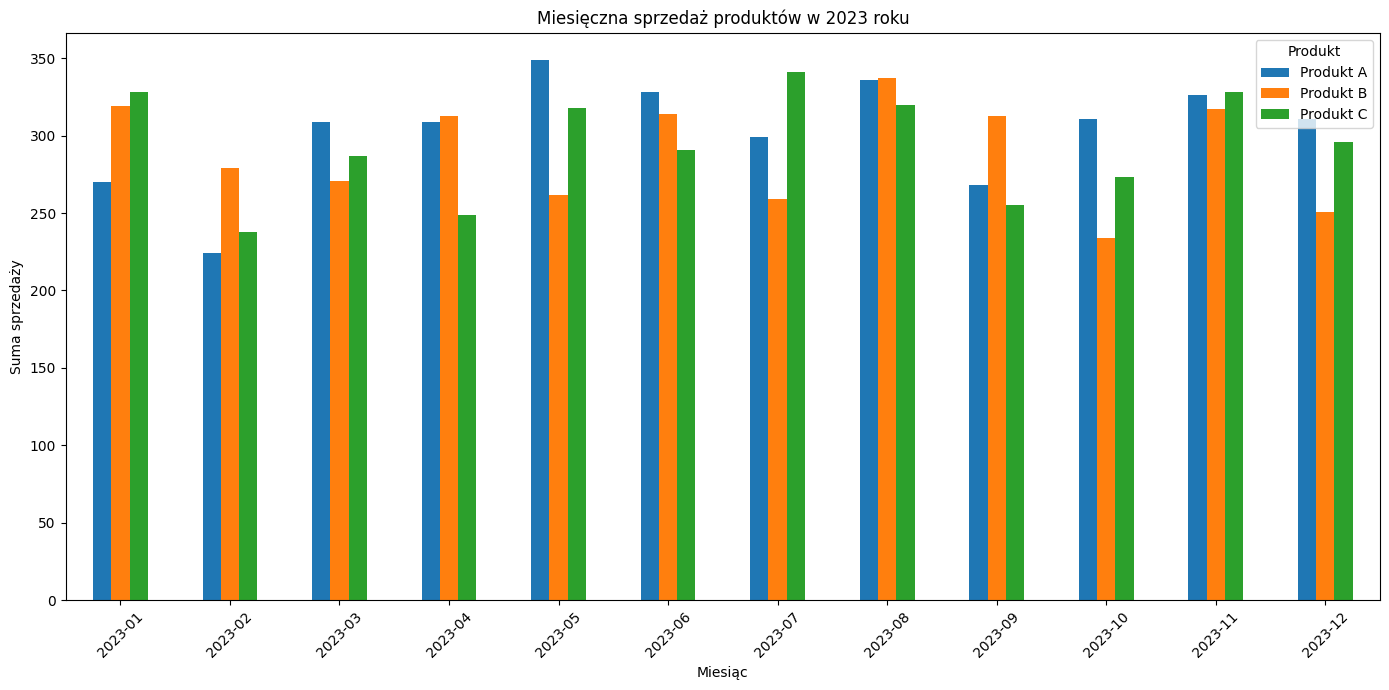

Podstawowe statystyki dla każdego produktu w 2023 roku:
           count      mean       std  min  25%   50%   75%   max
Produkt                                                         
Produkt A  365.0  9.972603  5.651929  1.0  5.0  10.0  15.0  19.0
Produkt B  365.0  9.504110  5.535411  1.0  5.0   9.0  14.0  19.0
Produkt C  365.0  9.654795  5.746118  1.0  5.0   9.0  15.0  19.0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
df = pd.read_csv('sprzedaz_produktow_2023.csv')
df['Data'] = pd.to_datetime(df['Data'])

# Dodanie kolumny z miesiącem i rokiem
df['Miesiąc'] = df['Data'].dt.to_period('M')

# Agregacja danych po miesiącu i produkcie
df_miesieczna = df.groupby(['Miesiąc', 'Produkt'])['Ilość'].sum().unstack().fillna(0)

# Wykres sprzedaży miesięcznej dla każdego produktu
df_miesieczna.plot(kind='bar', figsize=(14, 7))
plt.title('Miesięczna sprzedaż produktów w 2023 roku')
plt.xlabel('Miesiąc')
plt.ylabel('Suma sprzedaży')
plt.xticks(rotation=45)
plt.legend(title='Produkt')
plt.tight_layout()
plt.show()

# Analiza statystyczna
print("Podstawowe statystyki dla każdego produktu w 2023 roku:")
print(df.groupby('Produkt')['Ilość'].describe())


In [ ]:
pip install python-pptx pandas openpyxl

In [3]:
from pptx import Presentation
from pptx.util import Inches
import matplotlib.pyplot as plt
import tempfile
import os

def eksportuj_do_powerpoint(df_miesieczna):
    prs = Presentation()
    for miesiac, dane in df_miesieczna.iteritems():
        # Tworzenie wykresu
        fig, ax = plt.subplots(figsize=(10, 6))
        dane.plot(kind='bar', ax=ax)
        plt.title(f'Sprzedaż produktów w {miesiac}')
        plt.ylabel('Ilość sprzedanych sztuk')
        plt.xlabel('Produkt')
        plt.tight_layout()
        
        # Zapis wykresu do pliku tymczasowego
        tmpfile = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
        plt.savefig(tmpfile.name)
        plt.close()

        # Dodanie slajdu do prezentacji
        slide_layout = prs.slide_layouts[5]  # Używamy układu pustego slajdu
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title
        title.text = f"Sprzedaż produktów - {miesiac}"

        # Dodanie wykresu do slajdu
        slide.shapes.add_picture(tmpfile.name, Inches(0.5), Inches(1.5), width=Inches(9))

        # Usuwanie pliku tymczasowego
        os.unlink(tmpfile.name)

    # Zapis prezentacji do pliku
    prs.save('sprzedaz_produktow_2023.pptx')
    print("Prezentacja została zapisana jako 'sprzedaz_produktow_2023.pptx'.")

# Wywołanie funkcji eksportu do PowerPoint
eksportuj_do_powerpoint(df_miesieczna)


/var/folders/8l/t3zs7y694s5g088bzybz9czc0000gn/T/ipykernel_42639/27529576.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for miesiac, dane in df_miesieczna.iteritems():


Prezentacja została zapisana jako 'sprzedaz_produktow_2023.pptx'.


In [4]:
def eksportuj_do_excela(df, nazwa_pliku='sprzedaz_produktow_2023.xlsx'):
    with pd.ExcelWriter(nazwa_pliku, engine='openpyxl') as writer:
        for nazwa, grupa in df.groupby(df['Data'].dt.to_period('M')):
            miesieczne_dane = grupa.groupby(['Data', 'Produkt'])['Ilość'].sum().unstack().fillna(0)
            miesieczne_dane.to_excel(writer, sheet_name=str(nazwa))

    print(f"Dane zostały zapisane do pliku Excel '{nazwa_pliku}'.")

# Wywołanie funkcji eksportu do Excela
eksportuj_do_excela(df)


Dane zostały zapisane do pliku Excel 'sprzedaz_produktow_2023.xlsx'.


In [5]:
from openpyxl.chart import BarChart, Reference

def eksportuj_do_excela_z_wykresami(df, nazwa_pliku='sprzedaz_produktow_2023_z_wykresami.xlsx'):
    with pd.ExcelWriter(nazwa_pliku, engine='openpyxl') as writer:
        for nazwa, grupa in df.groupby(df['Data'].dt.to_period('M')):
            miesieczne_dane = grupa.groupby(['Produkt'])['Ilość'].sum().to_frame().reset_index()
            miesieczne_dane.to_excel(writer, sheet_name=str(nazwa), index=False)
            
            # Pobranie arkusza
            arkusz = writer.sheets[str(nazwa)]
            
            # Dodanie wykresu
            wykres = BarChart()
            wykres.type = "col"
            wykres.style = 10
            wykres.title = "Sprzedaż produktów"
            wykres.y_axis.title = 'Ilość'
            wykres.x_axis.title = 'Produkt'
            
            # Dane dla wykresu
            maks_rzedy = len(miesieczne_dane) + 1
            dane = Reference(arkusz, min_col=2, min_row=1, max_row=maks_rzedy, max_col=2)
            kategorie = Reference(arkusz, min_col=1, min_row=2, max_row=maks_rzedy)
            wykres.add_data(dane, titles_from_data=True)
            wykres.set_categories(kategorie)
            
            # Dodanie wykresu do arkusza
            arkusz.add_chart(wykres, "E2")

    print(f"Dane wraz z wykresami zostały zapisane do pliku Excel '{nazwa_pliku}'.")

# Wywołanie funkcji eksportu do Excela z wykresami
eksportuj_do_excela_z_wykresami(df)


Dane wraz z wykresami zostały zapisane do pliku Excel 'sprzedaz_produktow_2023_z_wykresami.xlsx'.


In [ ]:
def utworz_excel_z_tabela_przestawna(df, nazwa_pliku='sprzedaz_produktow_tabela_przestawna.xlsx'):
    # Tworzenie tabeli przestawnej
    tabela_przestawna = pd.pivot_table(df, values='Ilość', index='Produkt',
                                       columns=df['Data'].dt.month, aggfunc=np.sum, fill_value=0)
    
    # Przygotowanie miesięcy jako nazwy kolumn
    miesiace = {1: 'Styczeń', 2: 'Luty', 3: 'Marzec', 4: 'Kwiecień', 5: 'Maj', 6: 'Czerwiec',
                7: 'Lipiec', 8: 'Sierpień', 9: 'Wrzesień', 10: 'Październik', 11: 'Listopad', 12: 'Grudzień'}
    tabela_przestawna = tabela_przestawna.rename(columns=miesiace)
    
    # Zapis do pliku Excel
    with pd.ExcelWriter(nazwa_pliku, engine='openpyxl') as writer:
        tabela_przestawna.to_excel(writer, sheet_name='Tabela Przestawna')
    
    print(f"Tabela przestawna została zapisana do pliku Excel '{nazwa_pliku}'.")

# Wywołanie funkcji
utworz_excel_z_tabela_przestawna(df)


In [6]:
def utworz_excel_z_tabela_przestawna(df, nazwa_pliku='sprzedaz_produktow_tabela_przestawna.xlsx'):
    # Tworzenie tabeli przestawnej
    tabela_przestawna = pd.pivot_table(df, values='Ilość', index='Produkt',
                                       columns=df['Data'].dt.month, aggfunc=np.sum, fill_value=0)
    
    # Przygotowanie miesięcy jako nazwy kolumn
    miesiace = {1: 'Styczeń', 2: 'Luty', 3: 'Marzec', 4: 'Kwiecień', 5: 'Maj', 6: 'Czerwiec',
                7: 'Lipiec', 8: 'Sierpień', 9: 'Wrzesień', 10: 'Październik', 11: 'Listopad', 12: 'Grudzień'}
    tabela_przestawna = tabela_przestawna.rename(columns=miesiace)
    
    # Zapis do pliku Excel
    with pd.ExcelWriter(nazwa_pliku, engine='openpyxl') as writer:
        tabela_przestawna.to_excel(writer, sheet_name='Tabela Przestawna')
    
    print(f"Tabela przestawna została zapisana do pliku Excel '{nazwa_pliku}'.")

# Wywołanie funkcjibbb
utworz_excel_z_tabela_przestawna(df)

Tabela przestawna została zapisana do pliku Excel 'sprzedaz_produktow_tabela_przestawna.xlsx'.


In [ ]:
miesiace = {1: 'Styczeń', 2: 'Luty', 3: 'Marzec', 4: 'Kwiecień', 5: 'Maj', 6: 'Czerwiec',
                7: 'Lipiec', 8: 'Sierpień', 9: 'Wrzesień', 10: 'Październik', 11: 'Listopad', 12: 'Grudzień'}

tabela_przestawna = pd.pivot_table(df, values='Ilość', index='Produkt',
                                       columns=df['Data'].dt.month, aggfunc=np.sum, fill_value=0)
tabela_przestawna = tabela_przestawna.rename(columns=miesiace)

In [ ]:
tabela_przestawna